In [1]:
from collections import Counter
from datetime import datetime, timedelta
import warnings

from   hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
DATA = '../data'
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2023, 1, 21)

In [3]:
sp = yf.download(
    '^GSPC', start='1965-01-01', end=str(TOMORROW)).sort_index()
nyse = yf.download(
    '^NYA', start='1965-01-01', end=str(TOMORROW)).sort_index()
nas = yf.download(
    '^IXIC', start='1965-01-01', end=str(TOMORROW)).sort_index()
wil = yf.download(
    '^W5000', start='1990-01-01', end=str(TOMORROW))

path = '../data'
sp.to_csv(f'{path}/sp1950.csv')
nyse.to_csv(f'{path}/nya1965.csv')
nas.to_csv(f'{path}/nasdaq1965.csv')
wil.to_csv(f'{path}/wilshire1990.csv')

#sp = pd.read_csv(f'{DATA}/sp1950.csv')
#nyse = pd.read_csv(f'{DATA}/nya1965.csv')
#nas = pd.read_csv(f'{DATA}/nasdaq1965.csv')
#wil = pd.read_csv(f'{DATA}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
sp.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-13,3960.600098,4003.949951,3947.669922,3999.090088,3999.090088,3939700000
2023-01-17,3999.280029,4015.389893,3984.570068,3990.969971,3990.969971,4235560000
2023-01-18,4002.250000,4014.159912,3926.590088,3928.860107,3928.860107,4298710000
2023-01-19,3911.840088,3922.939941,3885.540039,3898.850098,3898.850098,3991500000
2023-01-20,3909.040039,3972.959961,3897.860107,3972.610107,3972.610107,2603614000


In [5]:
x = sp['Adj Close'].to_numpy()
np.append([np.nan], x[1:] / x[:-1])

array([       nan, 1.00474883, 1.00307222, ..., 0.9844374 , 0.99236165,
       1.0189184 ])

In [6]:
def get_daily_changes(series):
    x = series.to_numpy()
    return np.append([1], x[1:] / x[:-1])

In [7]:
def prep_df(df, name):
    df.index = pd.to_datetime(df.index)
    df[f'{name}_daily'] = get_daily_changes(df['Adj Close'])
    df.rename(columns={'Adj Close': name}, inplace=True)
    return df[[name, f'{name}_daily']]

In [8]:
[sp, nyse, nas, wil] = [
    prep_df(df, name) 
    for df, name in zip(
        [sp, nyse, nas, wil], ['sp', 'nyse', 'nas', 'wil'])]
sp.head()

,sp,sp_daily
Date,,
1965-01-04,84.230003,1.000000
1965-01-05,84.629997,1.004749
1965-01-06,84.889999,1.003072
1965-01-07,85.260002,1.004359
1965-01-08,85.370003,1.001290


In [9]:
nyse.head()

,nyse,nyse_daily
Date,,
1965-12-31,528.690002,1.000000
1966-01-03,527.210022,0.997201
1966-01-04,527.840027,1.001195
1966-01-05,531.119995,1.006214
1966-01-06,532.070007,1.001789


In [10]:
nas.head()

,nas,nas_daily
Date,,
1971-02-05,100.000000,1.000000
1971-02-08,100.839996,1.008400
1971-02-09,100.760002,0.999207
1971-02-10,100.690002,0.999305
1971-02-11,101.449997,1.007548


In [11]:
def find_best_mod(
        daily,
        n_states=[6, 7, 8],
        max_iter=1000,
        reps=3,
        best_logprob=None,
        best_mod=None):
    daily = np.reshape(daily.values, [-1, 1])
    best_logprob = best_logprob or -np.inf
    best_mod = best_mod or None
    for states in n_states:
        for rep in range(reps):
            try:
                print(f'rep {rep + 1}', end='\r')
                for cov in ['spherical', 'diag', 'full']:
                    mod = GaussianHMM(
                        n_components=states, covariance_type=cov, n_iter=max_iter
                    ).fit(daily)
                    logprob = mod.score(daily)
                    if logprob > best_logprob:
                        print(f'New best - States: {states} (cov: {cov})')
                        best_logprob = logprob
                        best_mod = mod
            except ValueError:
                pass
    return best_mod, best_logprob

In [12]:
def get_preds(daily, mod):
    daily = np.reshape(daily.values, [-1, 1])
    states = mod.predict(daily)
    means = np.squeeze(mod.means_)
    sds = np.squeeze(np.sqrt(mod.covars_))
    preds = np.array([means[state] for state in states])
    ses = np.array([1.96 * sds[state] for state in states])
    return preds, ses, means, states[-1]

In [13]:
def plot_mod(df, preds, ses, name):
    daily = f'{name}_daily'
    plt.plot(df[daily], label='daily')
    plt.plot(df.index, preds, label='preds')
    plt.legend()

    plt.figure()
    plt.plot(df[daily], label='daily')
    plt.plot(
        df.index, preds, label='preds', color='orange', linewidth=3)
    plt.plot(df.index, preds + ses, color='orange', linestyle='-.')
    plt.plot(df.index, preds - ses, color='orange', linestyle='-.')
    plt.axhline(y=1, color='k')
    plt.ylim([0.95, 1.05]);
    plt.xlim([df.index[-500], df.index[-1]])

    plt.figure()
    plt.plot(df[name])
    plt.xlim([df.index[-500], df.index[-1]])
    sub = df.iloc[-500:, :]
    plt.ylim(
        0.95 * sub[name].min(), 1.05 * sub[name].max());

In [14]:
def get_expected_val(mod, current_state, means):
    return np.dot(mod.transmat_[current_state, :], means)

## S&P

In [15]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [16]:
sp_prob = None
sp_mod = None

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


0.9999741872711773


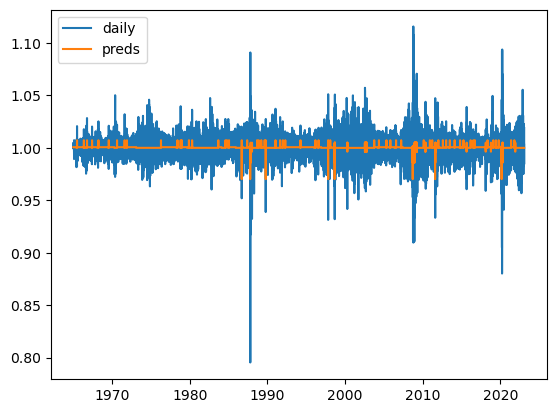

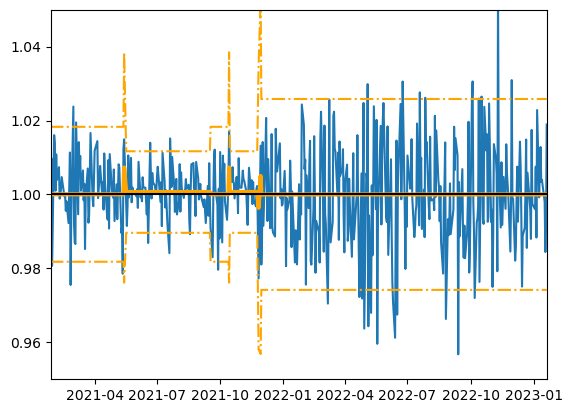

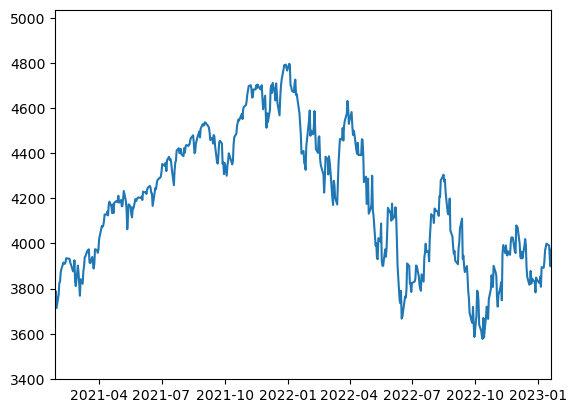

In [104]:
sp_mod, sp_prob = find_best_mod(
    sp.sp_daily,
    n_states=range(3, 11),
    best_logprob=sp_prob,
    best_mod=sp_mod)
sp_preds, sp_ses, sp_means, sp_current = get_preds(sp.sp_daily, sp_mod)
plot_mod(sp, sp_preds, sp_ses, 'sp')
sp_exp = get_expected_val(sp_mod, sp_current, sp_means)
print(sp_exp)

## NYSE

In [18]:
nyse_prob = None
nyse_mod = None

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


1.000820947757718


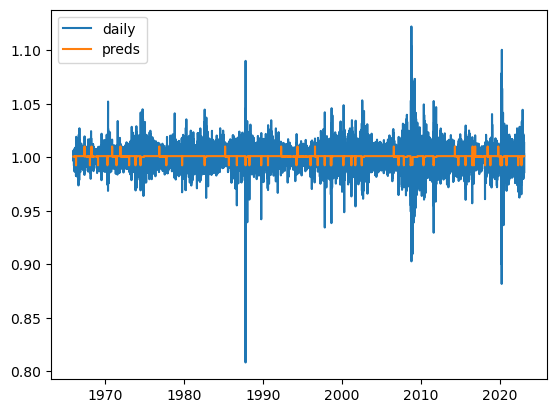

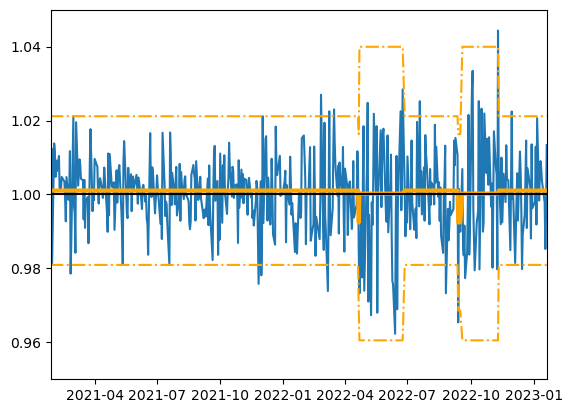

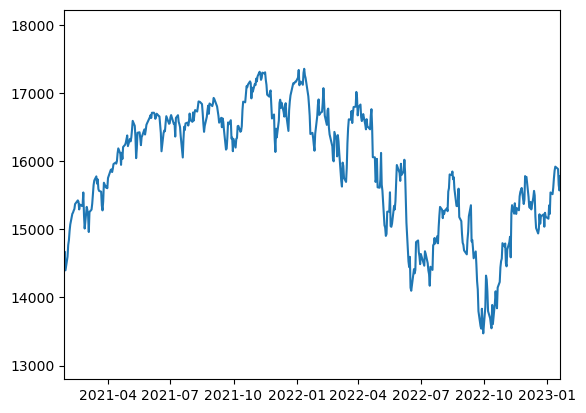

In [105]:
nyse_mod, nyse_prob = find_best_mod(
    nyse.nyse_daily,
    n_states=range(3, 11),
    best_logprob=nyse_prob,
    best_mod=nyse_mod)
nyse_preds, nyse_ses, nyse_means, nyse_current = get_preds(
    nyse.nyse_daily, nyse_mod)
plot_mod(nyse, nyse_preds, nyse_ses, 'nyse')
nyse_exp = get_expected_val(nyse_mod, nyse_current, nyse_means)
print(nyse_exp)

## Nasdaq

In [20]:
nas_prob = None
nas_mod = None

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


1.000725707256198


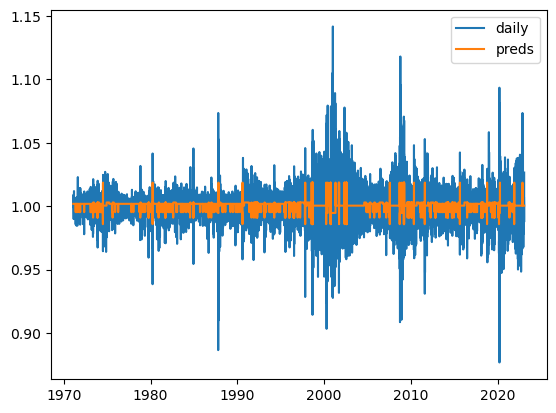

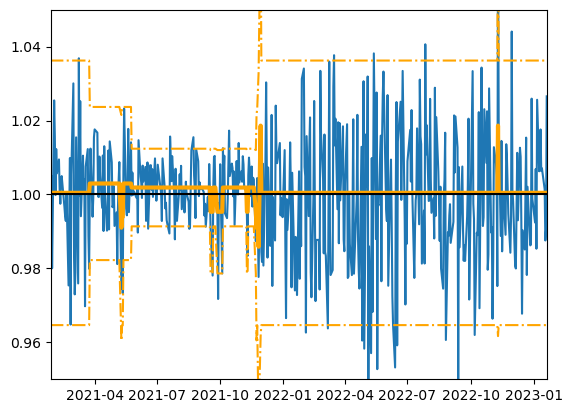

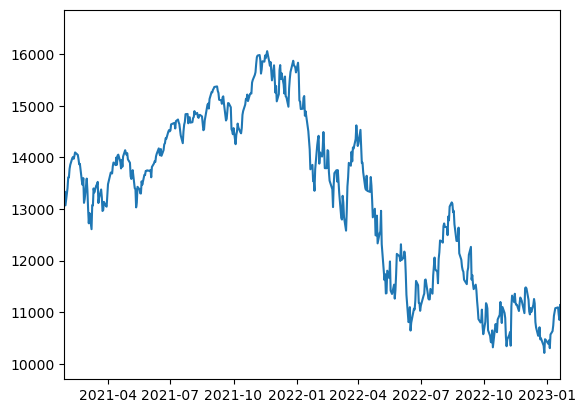

In [124]:
nas_mod, nas_prob = find_best_mod(
    nas.nas_daily,
    n_states=range(3, 11),
    best_logprob=nas_prob,
    best_mod=nas_mod)
nas_preds, nas_ses, nas_means, nas_current = get_preds(
    nas.nas_daily, nas_mod)
plot_mod(nas, nas_preds, nas_ses, 'nas')
nas_exp = get_expected_val(nas_mod, nas_current, nas_means)
print(nas_exp)

## Wilshire

In [22]:
wil_prob = None
wil_mod = None

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


0.9989457823755133


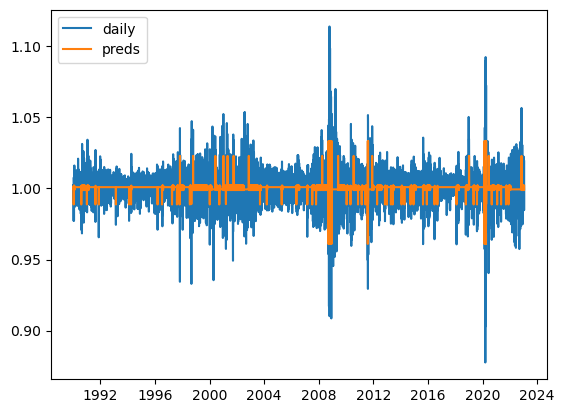

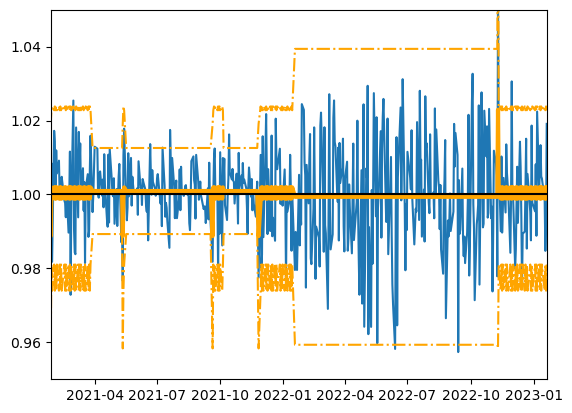

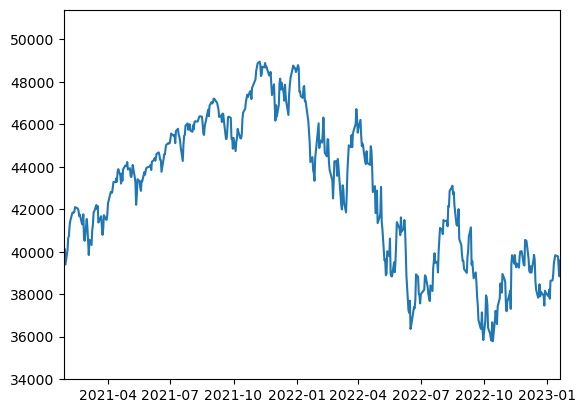

In [107]:
wil_mod, wil_prob = find_best_mod(
    wil.wil_daily,
    n_states=range(3, 11),
    best_logprob=wil_prob,
    best_mod=wil_mod)
wil_preds, wil_ses, wil_means, wil_current = get_preds(
    wil.wil_daily, wil_mod)
plot_mod(wil, wil_preds, wil_ses, 'wil')
wil_exp = get_expected_val(wil_mod, wil_current, wil_means)
print(wil_exp)

In [125]:
mean_states = (7 + 7 + 9 + 10) / 4
mean_states

8.25

In [126]:
N_STATES = int(round(mean_states))
N_STATES

8

In [127]:
exp = (sp_exp + nyse_exp + nas_exp + wil_exp) / 4
exp

1.0001166561651518

In [128]:
for df, name, exp in zip(
        [sp, nyse, nas, wil],
        ['sp', 'nyse', 'nas', 'wil'],
        [sp_preds, nyse_preds, nas_preds, wil_preds]):
    df[f'{name}_exp'] = exp

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_34679/3186342578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{name}_exp'] = exp


In [129]:
df = pd.concat([sp, nyse, nas, wil], axis=1)
df.tail()

,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp
Date,,,,,,,,,,,,
2023-01-13,3999.090088,1.003997,1.000009,15918.370117,1.003709,1.001059,11079.160156,1.007096,1.000447,39834.101562,1.004312,1.001918
2023-01-17,3990.969971,0.997970,1.000009,15883.559570,0.997813,1.001059,11095.110352,1.001440,1.000447,39774.148438,0.998495,0.998900
2023-01-18,3928.860107,0.984437,1.000009,15649.129883,0.985241,1.001059,10957.009766,0.987553,1.000447,39167.359375,0.984744,1.001918
2023-01-19,3898.850098,0.992362,1.000009,15569.629883,0.994920,1.001059,10852.269531,0.990441,1.000447,38840.679688,0.991659,0.998900
2023-01-20,3972.610107,1.018918,1.000009,15777.440430,1.013347,1.001059,11140.434570,1.026553,1.000447,39582.679688,1.019104,1.001918


In [130]:
df['mean_exp'] = (
    df[['sp_exp', 'nyse_exp', 'nas_exp', 'wil_exp']].mean(axis=1))

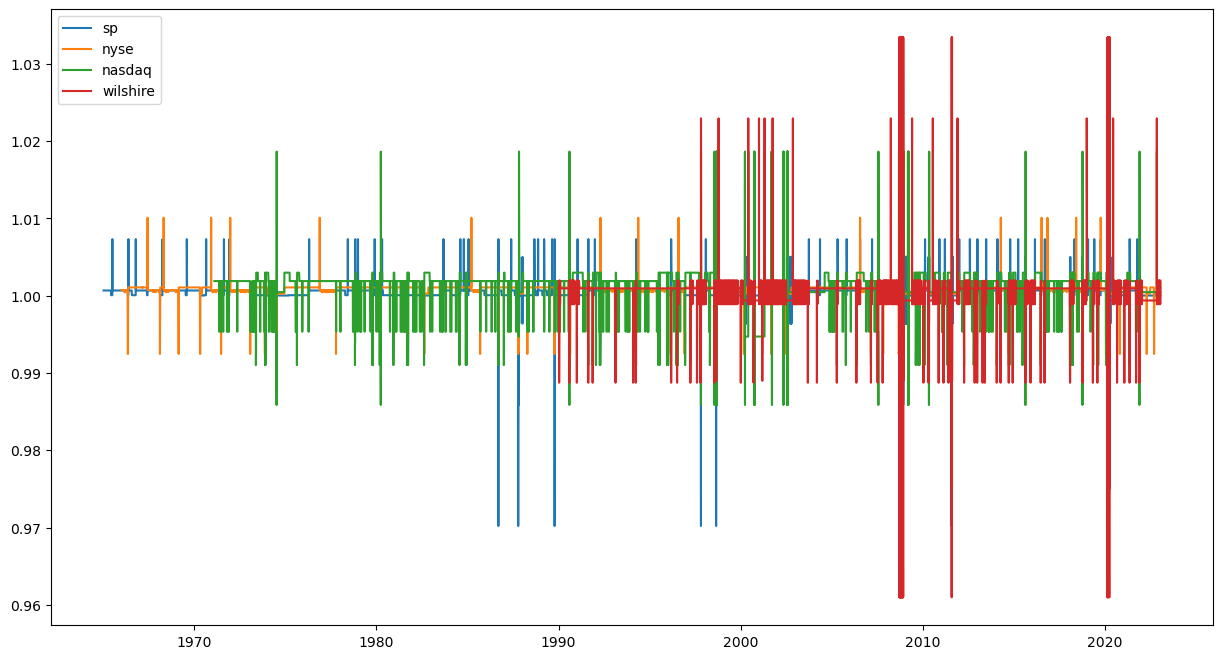

In [131]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, label='sp')
plt.plot(df.nyse_exp, label='nyse')
plt.plot(df.nas_exp, label='nasdaq')
plt.plot(df.wil_exp, label='wilshire')

plt.legend();

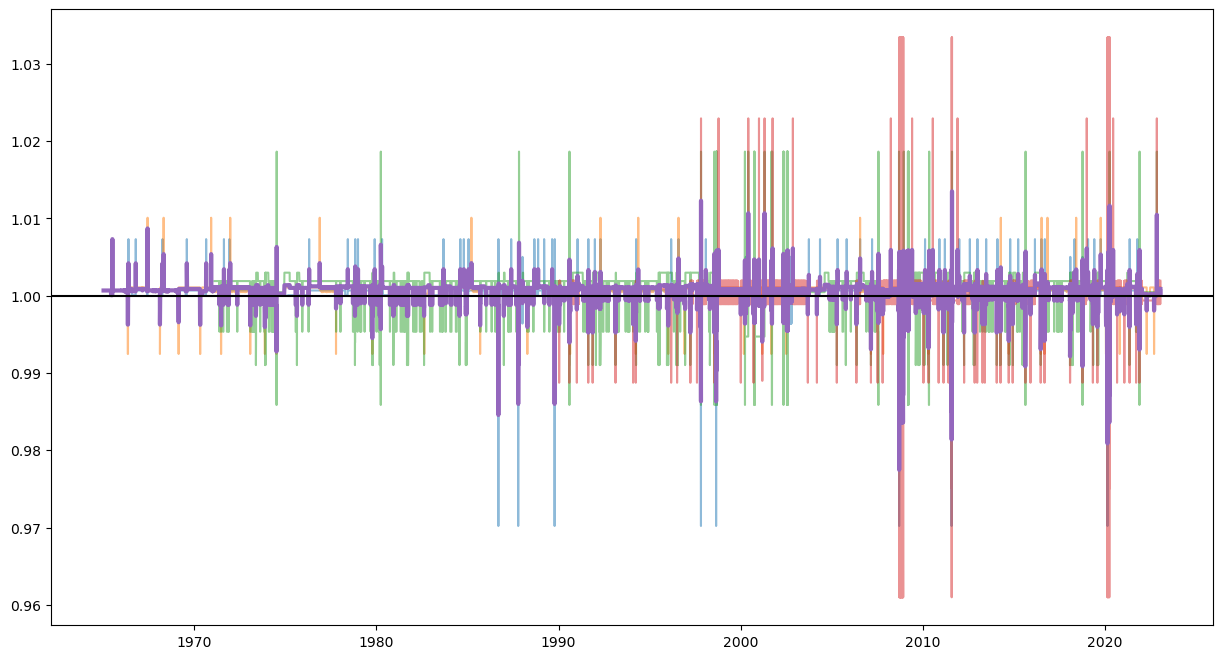

In [132]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k');

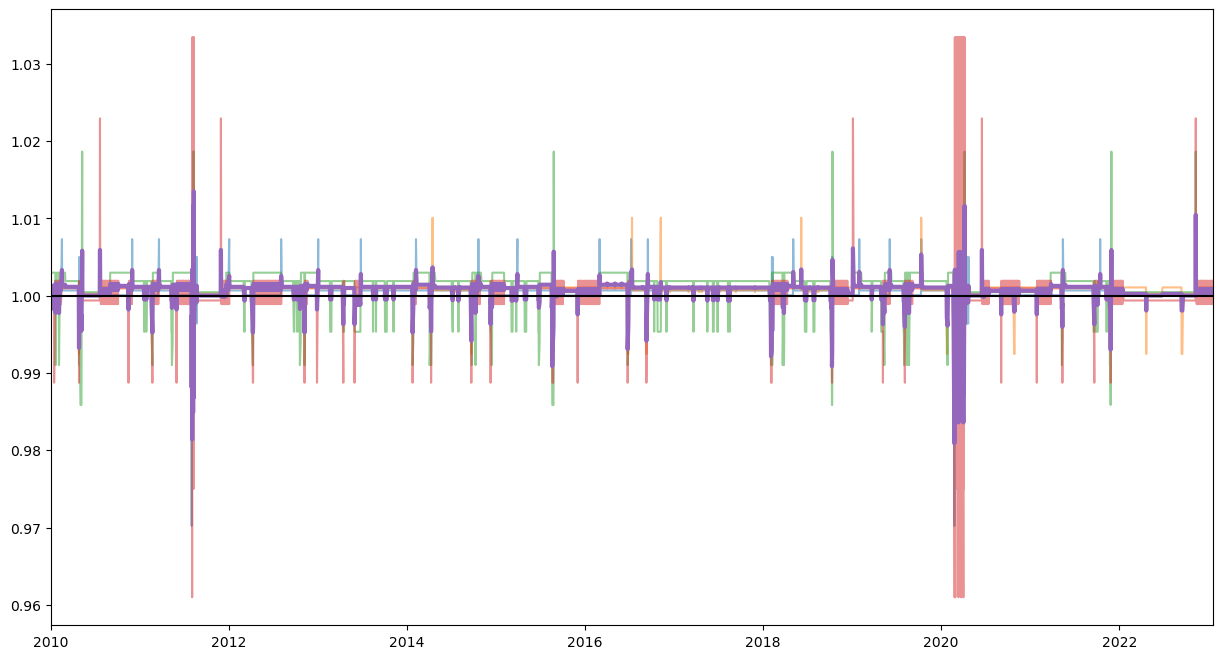

In [133]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

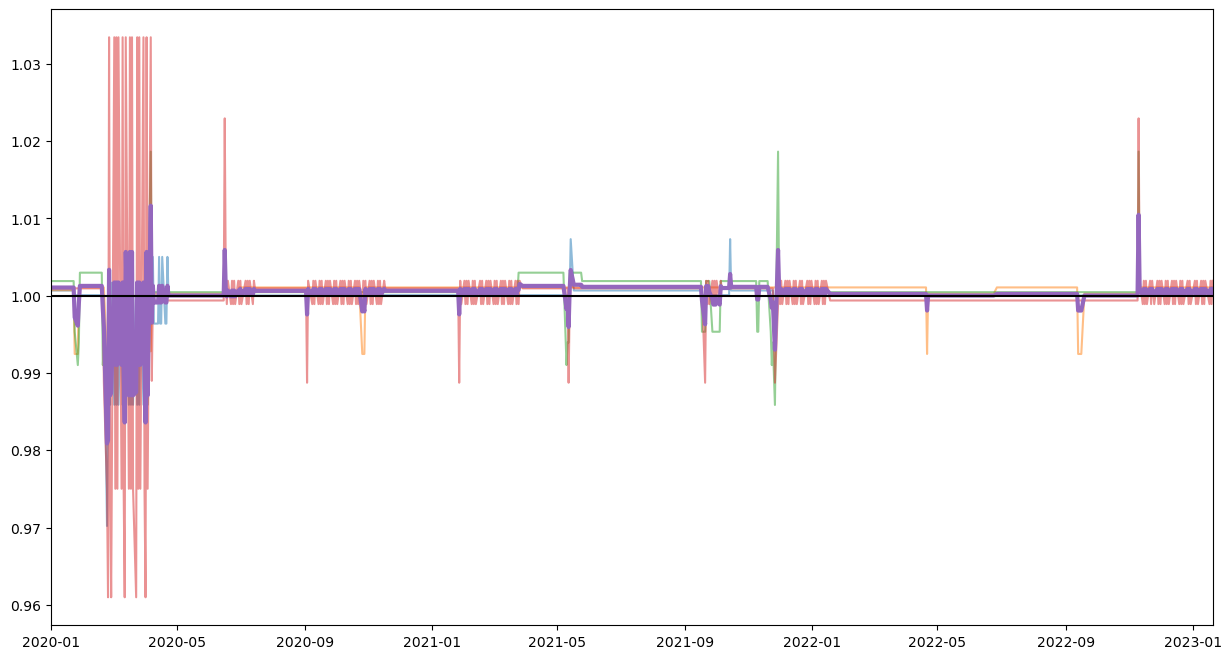

In [134]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.xlim(pd.to_datetime('2020-01-01'), TODAY);
plt.axhline(y = 1, color='k');

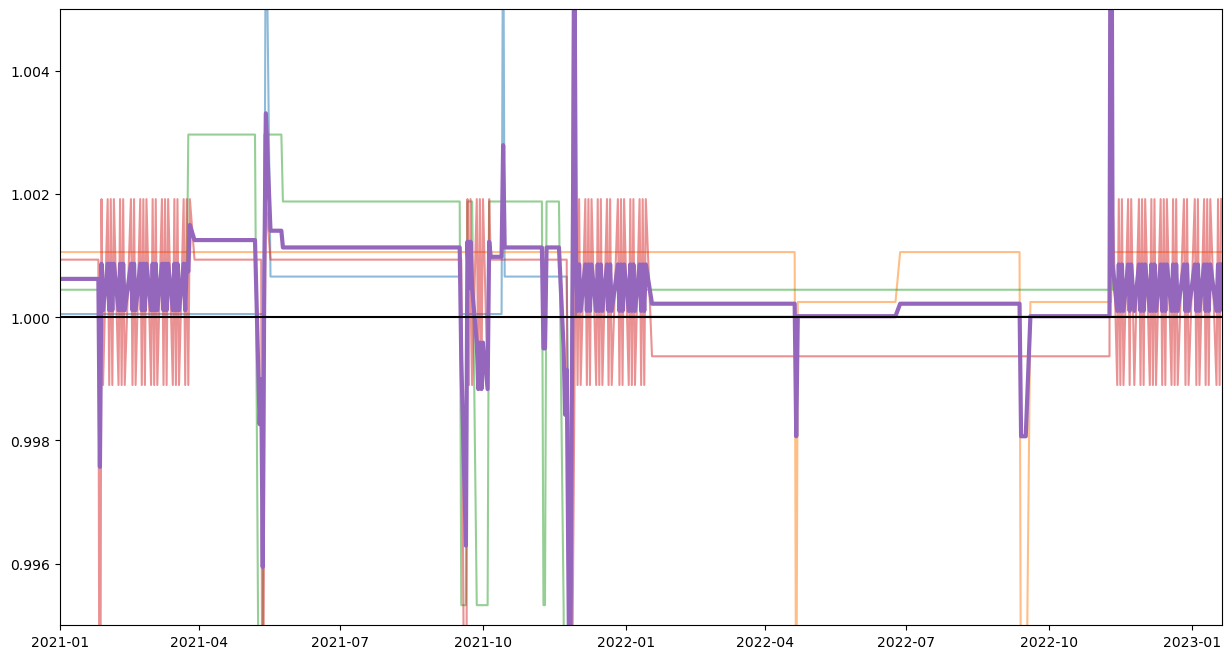

In [135]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2021-01-01'), TODAY)
plt.ylim([0.995, 1.005]);

In [136]:
df = df[df.index >= pd.to_datetime('1970-01-01')]

In [137]:
try:
    df['state'] = pd.qcut(
        df.mean_exp,
        N_STATES,
        retbins=False,
        duplicates='drop',
        labels=range(N_STATES))
except ValueError:
    try:
        df['state'] = pd.qcut(
            df.mean_exp,
            N_STATES,
            retbins=False,
            duplicates='drop',
            labels=range(N_STATES - 1))
    except ValueError:
        df['state'] = pd.qcut(
            df.mean_exp,
            N_STATES,
            retbins=False,
            duplicates='drop',
            labels=range(N_STATES - 2))

In [138]:
df.state.value_counts()

5    1923
3    1810
0    1805
2    1784
6    1689
1    1577
4    1474
7    1320
Name: state, dtype: int64

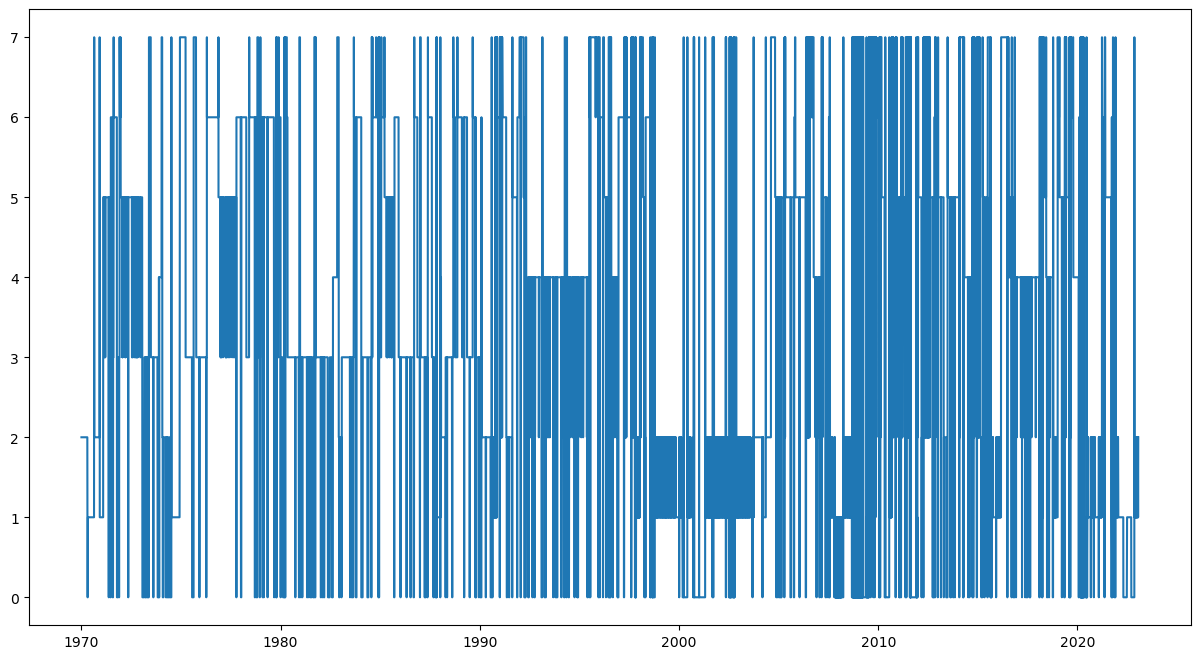

In [139]:
plt.figure(figsize=[15, 8])
plt.plot(df.state);

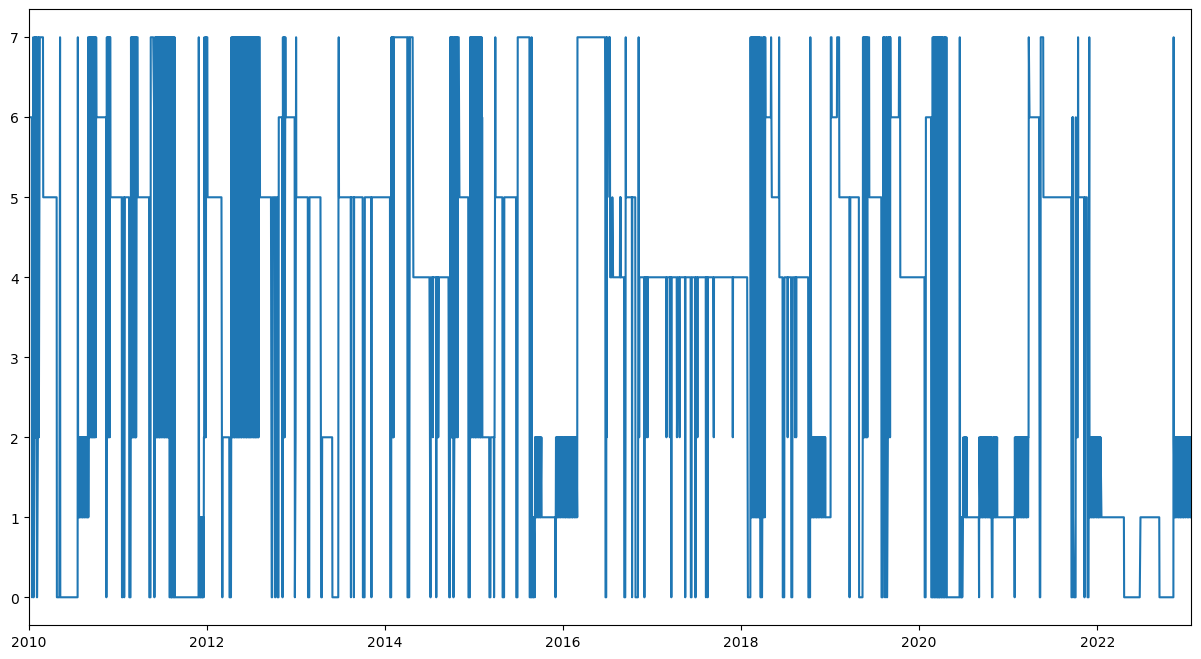

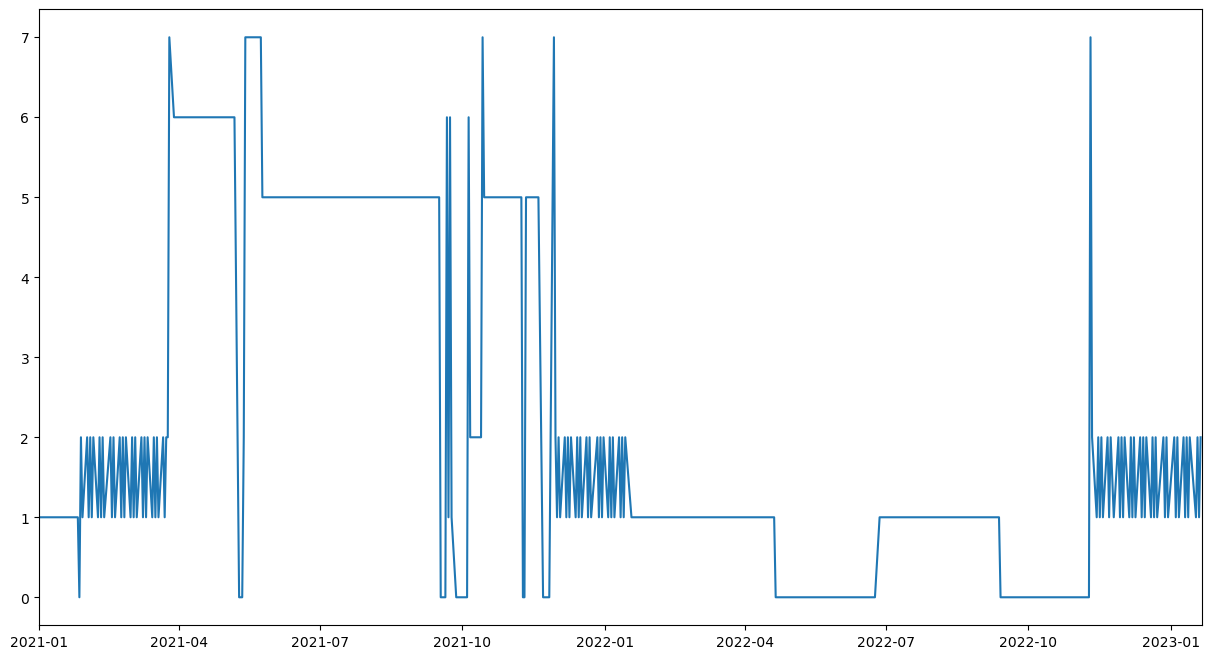

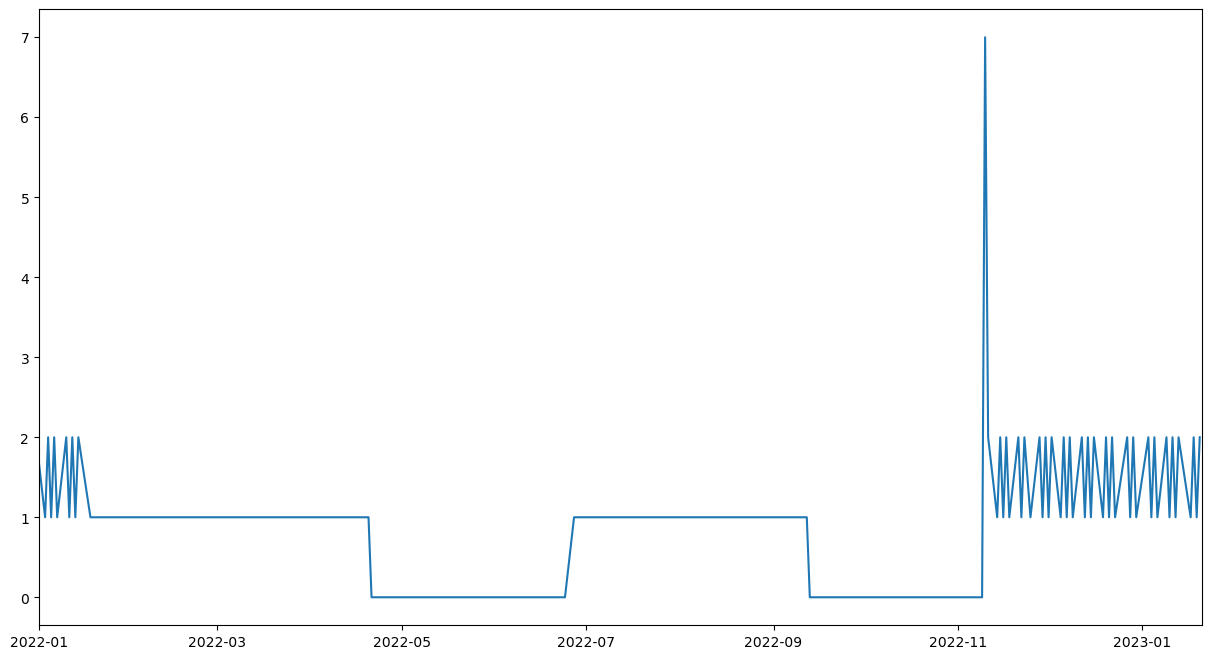

In [140]:
plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2021-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2022-01-01'), TODAY);

In [141]:
transitions = Counter()
for i in range(len(df.state) - 1):
    state = df.state[i]
    nxt = df.state[i + 1]
    transitions[(state, nxt)] += 1

In [142]:
df.to_csv(f'{DATA}/hmm_exp_returns.csv')

In [143]:
TODAY

datetime.datetime(2023, 1, 20, 14, 39, 6, 322403)

In [144]:
CURRENT_STATE = df.state[-1]
CURRENT_STATE

2

In [145]:
possible_transitions = sorted([k for k in transitions.keys() if k[0] == CURRENT_STATE])
state_sum = 0
for pt in possible_transitions:
    n_trans = transitions[pt]
    state_sum += n_trans
    print(f'{pt}: {n_trans}')

print()

data = []
for pt in possible_transitions:
    n_trans = transitions[pt]
    print(f'{pt}: {n_trans / state_sum:.4f}')
    data.append([pt[1], n_trans / state_sum])

(2, 0): 28
(2, 1): 690
(2, 2): 760
(2, 3): 1
(2, 4): 56
(2, 6): 1
(2, 7): 247

(2, 0): 0.0157
(2, 1): 0.3870
(2, 2): 0.4262
(2, 3): 0.0006
(2, 4): 0.0314
(2, 6): 0.0006
(2, 7): 0.1385


In [146]:
trans_df = pd.DataFrame(data, columns=['next_state', 'prob'])
trans_df

,next_state,prob
0,0,0.015704
1,1,0.386988
2,2,0.426248
3,3,0.000561
4,4,0.031408
5,6,0.000561
6,7,0.138531


In [147]:
trans_df.to_csv('../data/transition_probs.csv', index=False)

In [148]:
df.state.value_counts()

5    1923
3    1810
0    1805
2    1784
6    1689
1    1577
4    1474
7    1320
Name: state, dtype: int64

In [149]:
state_var = (
    df[['state', 'mean_exp']].groupby('state').agg(['mean', 'std']))
state_var.columns = ['mean', 'std']
state_var
state_var['ci'] = state_var.apply(
    lambda row: [
        row['mean'] - 1.96*row['std'],
        row['mean'] + 1.96*row['std']], axis=1)
state_var

,mean,std,ci
state,,,
0,0.998506,2.573123e-03,"[0.9934625178596416, 1.0035491605357658]"
1,1.000310,2.386919e-04,"[0.9998426560896619, 1.0007783282319789]"
2,1.000872,8.211709e-05,"[1.0007115249280734, 1.0010334239026935]"
3,1.000997,1.265184e-07,"[1.000996591233802, 1.0009970871857867]"
4,1.001045,7.626563e-06,"[1.0010305270520654, 1.0010604231797549]"
5,1.001115,2.573666e-05,"[1.0010642930173816, 1.0011651807399644]"
6,1.001218,2.530025e-05,"[1.001168114257152, 1.0012672912329617]"
7,1.001727,1.182154e-03,"[0.9994100431325856, 1.0040440869413616]"


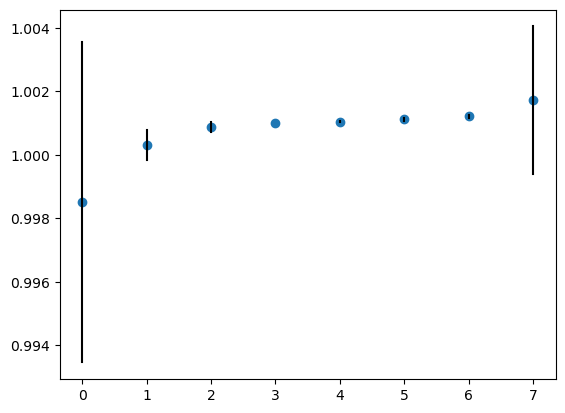

In [150]:
plt.scatter(state_var.index, state_var['mean'])
for state in range(state_var.index.max() + 1):
    plt.plot([state, state], state_var.loc[state, 'ci'], color='k');